In [1]:
#@title Colab Imports
import sys
import madi
from madi.utils import file_utils
import numpy as np
import pandas as pd
from typing import List, Dict
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns

from madi.datasets import gaussian_mixture_dataset
from madi.detectors.neg_sample_neural_net_detector import NegativeSamplingNeuralNetworkAD
from madi.detectors.integrated_gradients_interpreter import IntegratedGradientsInterpreter

import tensorflow as tf
assert tf.version.VERSION > '2.1.0'


In [2]:
#@title Plotting utilities
def plot_attribution(df_attribution: pd.DataFrame, anomaly_score: float) -> None:
  """Plots the attribution as a pie chart.

  The center contains the anmomaly score. The wedges are ordered clockwise
  from the most blame to the least. The percentages are the normalized
  percentages (Blame(d) / Sum of Blames). The values outside the wedges
  indicate the observed value, and the expected value in parentheses.

  Args:
    df_attribution: dataframe with observed_value, expected_value, and
    attribution for each dimension.
    anomaly_score: score ranging between Normal (1) and Anomalous (0).

  """
  df_attribution = df_attribution.sort_values(by='attribution', ascending=False)
  norm = plt.Normalize()
  names=[]
  sizes = []
  sum_big = 0
  for fn, row in df_attribution.iterrows():
    # Only show the dimensions with a blame > 5%.
    if row.attribution > 0.05:
      names.append('%s\n%3.1f (%3.1f)' %(fn, row.observed_value, row.expected_value))
      wedge_size = int(100* row.attribution)
      sum_big += wedge_size
      sizes.append(wedge_size)
  names.append('other')
  sizes.append(int(100 - sum_big))

  # Create a circle for the center of the plot
  num_p_score_steps = 100
  center_color_index  = int(num_p_score_steps*anomaly_score)
  my_circle=plt.Circle( (0,0), 0.45, facecolor=plt.cm.RdYlGn(
      norm(range(num_p_score_steps+1)))[center_color_index],
      edgecolor='white', linewidth=3)

  fig, ax = plt.subplots()
  fig.set_figheight(10)
  fig.set_figwidth(10)

  center_text = "%.2f" %(anomaly_score)
  if (center_color_index < 20 ) or (center_color_index > 80):
    text_color = 'white'
  else:
    text_color = 'black'
  ax.text(0,0,center_text, fontsize=28,horizontalalignment='center',
          color=text_color, weight="bold")

  # Custom colors --> colors will cycle
  norm = plt.Normalize()
  # Choose nine colors to cycle through to show contrast between slices.
  pie_plot = plt.pie(sizes, labels=names, colors=plt.cm.RdYlBu(norm(range(9)), alpha=0.6),
                     startangle=90, counterclock=False, autopct='%1.0f%%',
                     pctdistance=0.70, textprops=
                     dict(color="black", weight="bold", fontsize=28))

  for lab in pie_plot[1]:
    lab.set_fontsize(28)
  p=plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()

def plot_gradient_series(df_grad: pd.DataFrame, delta: np.array) -> None:
    fig, ax = plt.subplots()
    fig.set_figheight(12)
    fig.set_figwidth(15)
    n_points = len(df_grad)
    colors = sns.color_palette('rainbow', df_grad.shape[1])
    for ix, field_name in enumerate(df_grad):
      series_color = colors[ix]
      ig_series = (df_grad[field_name].cumsum()/float(n_points)) * delta[field_name]
      ax.plot(df_grad.index, ig_series , linewidth=3.0, linestyle='-', marker=None, color=series_color)

    ax.grid(linestyle='-', linewidth='0.5', color='darkgray')

    legend = plt.legend(loc='upper left', shadow=False, fontsize='16', bbox_to_anchor=(1, 1), labels = list(df_grad))
    legend.get_frame().set_facecolor('white')
    plt.ylabel('Cumulative Gradients')

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(24)

    for sp in ax.spines:
       ax.spines[sp].set_color("black")
    ax.set_facecolor("white")

    plt.grid(True)
    plt.show()

In [3]:
#@title Choose the data set
_RESOURCE_LOCATION = "madi.datasets.data"
data_source = "smart_buildings" #@param ["gaussian_mixture", "smart_buildings"]
ds = None

class InvalidDatasetError(ValueError):
    pass

if data_source == 'gaussian_mixture':
  contamination = 0.15

  ds = gaussian_mixture_dataset.GaussianMixtureDataset(
          n_dim=16,
          n_modes=2,
          n_pts_pos=8000,
          sample_ratio=contamination,
          upper_bound=3,
          lower_bound=-3)

  print('Loaded Gaussian mixture with 2 modes in 16 dimensions, with a sample size of %d.' %len(ds.sample))

elif data_source == 'smart_buildings':
  data_file = file_utils.PackageResource(
      _RESOURCE_LOCATION, "anomaly_detection_sample_1577622599.csv")
  readme_file = file_utils.PackageResource(
      _RESOURCE_LOCATION, "anomaly_detection_sample_1577622599_README.md")
  ds = madi.datasets.smart_buildings_dataset.SmartBuildingsDataset(data_file, readme_file)
  print(ds.description)

else:
  raise InvalidDatasetError("You requested an invalid data set (%s)." %data_source)


print('Randomize the data, and split into training and test sample.')
split_ix = int(len(ds.sample) * 0.8)
training_sample = ds.sample.iloc[:split_ix]
test_sample = ds.sample.iloc[split_ix:]
print("\tTraining sample size: %d" %len(training_sample))
print("\tTest sample size: %d" %len(test_sample))



The Smart Buildings Anomaly Detection dataset consists of 60,425
 multidimensional, multimodal observations derived from 15
 Variable Air Volume (VAV) climate control devices collected over 14 days
 between October 8 and October 21, 2019, from a Google campus in the
 California Bay Area. In 1,921 (3.2%) anomalous observations, the devices
 are unable to maintain setpoint, and are of interest to facilities
 technicians. A setpoint is maintained when the zone air temperature
 remains above the zone air heating setpoint, and below the zone air
 cooling setpoint. On Mondays through Fridays, from 6:00 am to 10:00 pm
 local time, the devices operate in a comfort mode, with tight constraints
 between the heating and cooling setpoints. From 10:00 pm to 6:00 am, and
 on weekends the setpoints are wider to reduce energy consumption, and
 hence, there are comfort and eco operating modes. The data had seven
 numeric dimensions: zone air cooling temperature setpoint, zone air
 heating temperature s

In [4]:
#@title Train a Negative Sampling Neural Net (NS-NN) Anomaly Detector
log_dir = "logs/nsnn2" #@param {type:"string"}

nsnn_params = {}
if data_source == 'gaussian_mixture':

    nsnn_params['sample_ratio']=10.0
    nsnn_params['sample_delta']=0.05
    nsnn_params['batch_size']=16
    nsnn_params['steps_per_epoch']=80
    nsnn_params['epochs']=180
    nsnn_params['dropout']=0.7
    nsnn_params['layer_width']=145
    nsnn_params['n_hidden_layers']=3

elif data_source == 'smart_buildings':
    nsnn_params['sample_ratio']=25.0
    nsnn_params['sample_delta']=0.05
    nsnn_params['batch_size']=32
    nsnn_params['steps_per_epoch']=16
    nsnn_params['epochs']=88
    nsnn_params['dropout']=0.5
    nsnn_params['layer_width']=128
    nsnn_params['n_hidden_layers']=2

else:
  raise InvalidDatasetError("You requested an invalid data set (%s)." %data_source)

print(nsnn_params)
X_train = training_sample.drop(columns = ['class_label'])

# It's very important to normalize the data for both classification and
# anomaly detection.
y_train = training_sample['class_label']

# We shall reuse the normalization info from training for test.
X_test = test_sample.drop(columns = ['class_label'])
y_test= test_sample['class_label']

# Declare the AD and parameterize it.
ad = NegativeSamplingNeuralNetworkAD(
        sample_ratio=nsnn_params['sample_ratio'],
        sample_delta=nsnn_params['sample_delta'],
        batch_size=nsnn_params['batch_size'],
        steps_per_epoch=nsnn_params['steps_per_epoch'],
        epochs=nsnn_params['epochs'],
        dropout=nsnn_params['dropout'],
        layer_width=nsnn_params['layer_width'],
        n_hidden_layers=nsnn_params['n_hidden_layers'],
        log_dir=log_dir)

# Build the sample and train the AD classifier model.
ad.train_model(x_train=X_train)

xy_predicted = ad.predict(X_test)

auc = madi.utils.evaluation_utils.compute_auc(
      y_actual=y_test, y_predicted=xy_predicted['class_prob'])

print("The AUC against the test set is %0.3f" %auc)

{'sample_ratio': 25.0, 'sample_delta': 0.05, 'batch_size': 32, 'steps_per_epoch': 16, 'epochs': 88, 'dropout': 0.5, 'layer_width': 128, 'n_hidden_layers': 2}




d:\After\Fuse AI Trainee\proj\madi_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
The AUC against the test set is 0.807


In [5]:
#@title Set up the anomaly interpreter.


min_class_confidence = 0.99 #@param {type:"number"}
max_baseline_size = 500 #@param {type:"integer"}

try:
  X_train_normalized = madi.utils.sample_utils.normalize(X_train, ad._normalization_info)
  interpreter = madi.detectors.integrated_gradients_interpreter.IntegratedGradientsInterpreter(
          ad._model, X_train_normalized,
          min_class_confidence, max_baseline_size,num_steps_integrated_gradients = 2000)
  print('Variable Attibution is ready with a baseline sample size of %d points.' %len(interpreter._df_baseline))
except madi.detectors.integrated_gradients_interpreter.NoQualifyingBaselineError as err:
  print(err.message)
  print('Assign min_class_confidence to a value below %0.2f to accumulate a baseline sample.' %err.highest_class_confidence)
  print('Variable Attibution is NOT ready.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Variable Attibution is ready with a baseline sample size of 416 points.


In [6]:
#@title Generate the sliders for interactive control.

def get_variable_slider(variable_name:str, mean:float, std:float, default:float) -> str:
  if "percent" in variable_name:
    min_val = 0
    max_val = 100
    step = 1
  elif "temperature" in variable_name:
    min_val = 250
    max_val = 350
    step = 1
  elif variable_name == "dow":
    min_val = 0
    max_val = 6
    step = 1
  elif variable_name == "hod":
    min_val = 0
    max_val = 23
    step = 1
  else:
    min_val = mean - 6 * std
    max_val = mean + 6 * std
    step = (max_val - min_val)/100.0

  var_name_base = variable_name.replace("data:", "")
  return """%s = %f #%sparam {type:"slider", min:%f, max:%f, step:%f}""" %(var_name_base, default, "@", min_val, max_val, step )

def get_var_assignment(variable_name: str) -> str:
  var_name_base = variable_name.replace("data:", "")
  return """observed_point['%s'] = [%s]""" %(variable_name, var_name_base)

def get_sliders(normalization_info: Dict[str, madi.utils.sample_utils.Variable], baseline: pd.DataFrame):
  column_order = madi.utils.sample_utils.get_column_order(normalization_info)
  slider_strings  = []
  for col in column_order:
    slider_strings.append(get_variable_slider(col, normalization_info[col].mean, normalization_info[col].std, baseline[col]))
  return "\n".join(slider_strings)

def get_var_assignments(normalization_info):
  column_order = madi.utils.sample_utils.get_column_order(normalization_info)
  assignment_strings  = []
  for col in column_order:
    assignment_strings.append(get_var_assignment(normalization_info[col].name))
  return "\n".join(assignment_strings)

df_reference_point_selected_normalized = interpreter._df_baseline.iloc[[0]]
df_reference_point_selected =madi.utils.sample_utils.denormalize(df_reference_point_selected_normalized, ad._normalization_info)

print(get_sliders(ad._normalization_info,df_reference_point_selected.iloc[0]))
print(get_var_assignments(ad._normalization_info))

zone_air_heating_temperature_setpoint = 294.259259 #@param {type:"slider", min:250.000000, max:350.000000, step:1.000000}
zone_air_temperature_sensor = 296.148148 #@param {type:"slider", min:250.000000, max:350.000000, step:1.000000}
zone_air_cooling_temperature_setpoint = 297.037037 #@param {type:"slider", min:250.000000, max:350.000000, step:1.000000}
supply_air_flowrate_sensor = 0.058702 #@param {type:"slider", min:-0.524920, max:0.680442, step:0.012054}
supply_air_damper_percentage_command = 0.000000 #@param {type:"slider", min:0.000000, max:100.000000, step:1.000000}
supply_air_flowrate_setpoint = 0.023597 #@param {type:"slider", min:-0.458550, max:0.618666, step:0.010772}
dow = 0.000000 #@param {type:"slider", min:0.000000, max:6.000000, step:1.000000}
hod = 23.000000 #@param {type:"slider", min:0.000000, max:23.000000, step:1.000000}
observed_point['data:zone_air_heating_temperature_setpoint'] = [zone_air_heating_temperature_setpoint]
observed_point['data:zone_air_temperature_se

If you're getting an error, please open this cell and paste the output from the last cell here.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


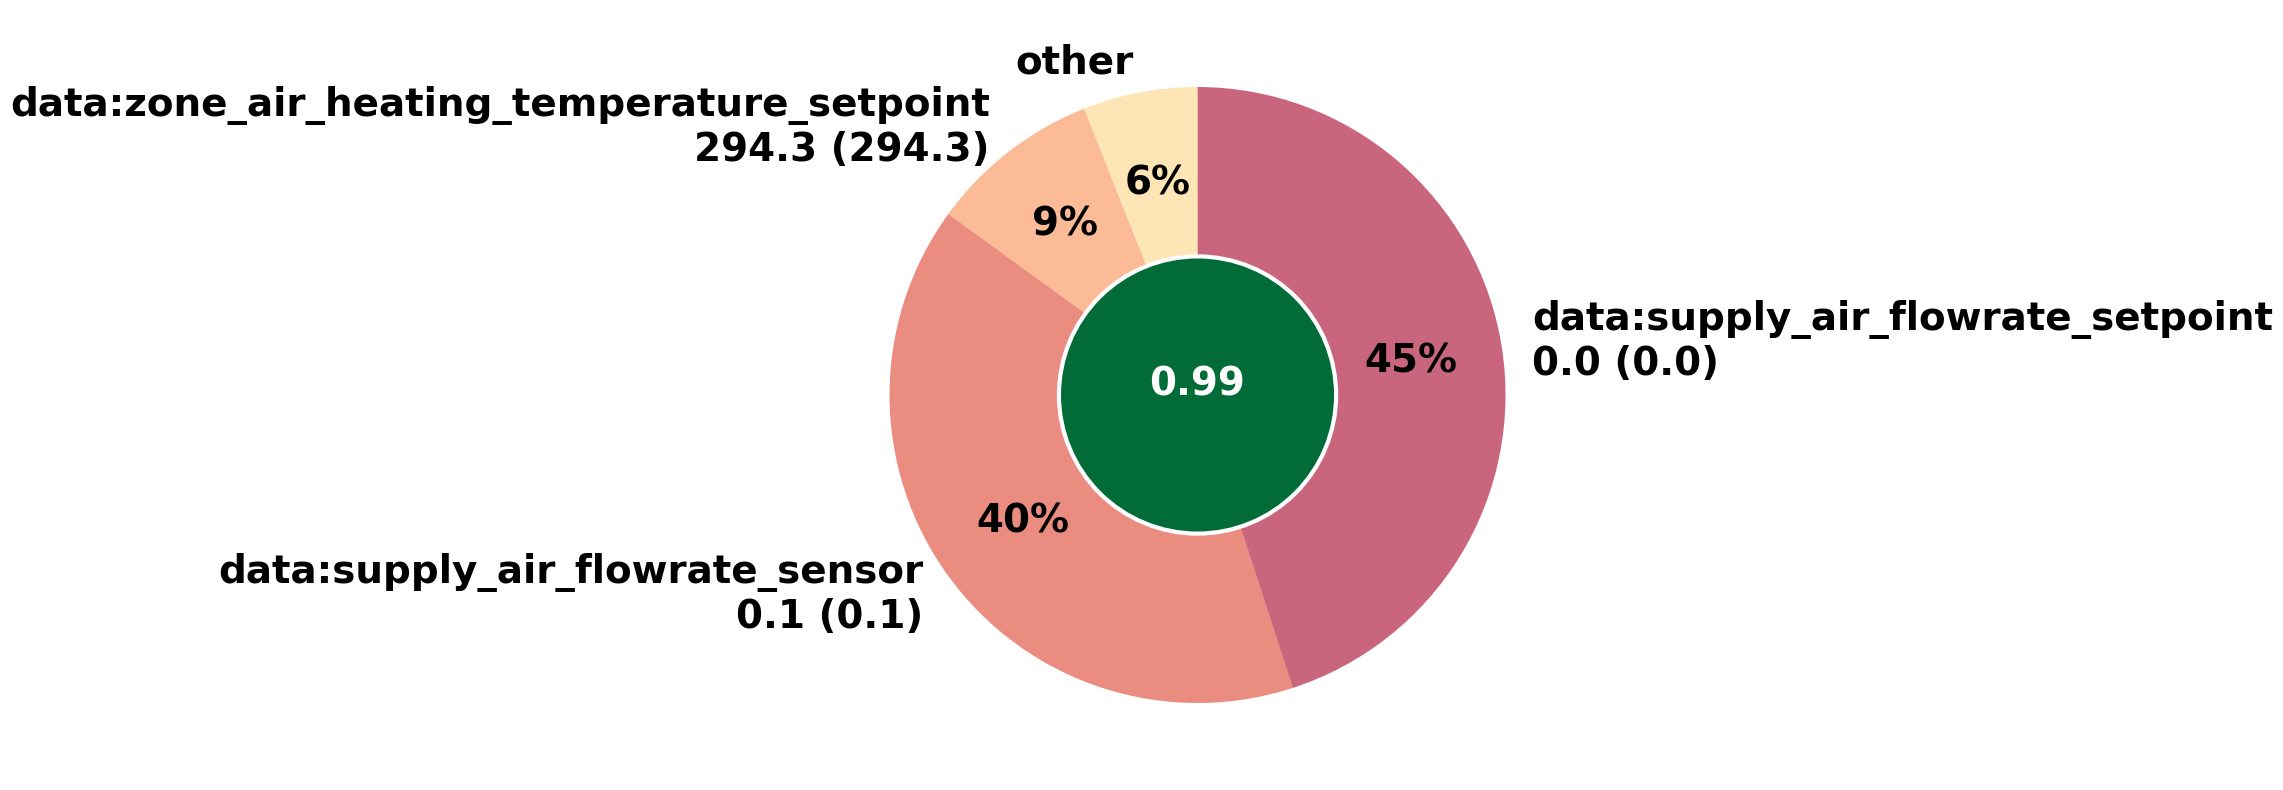

C:\Users\OMEN\AppData\Local\Temp\ipykernel_1604\1817222474.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ig_series = (df_grad[field_name].cumsum()/float(n_points)) * delta[field_name]


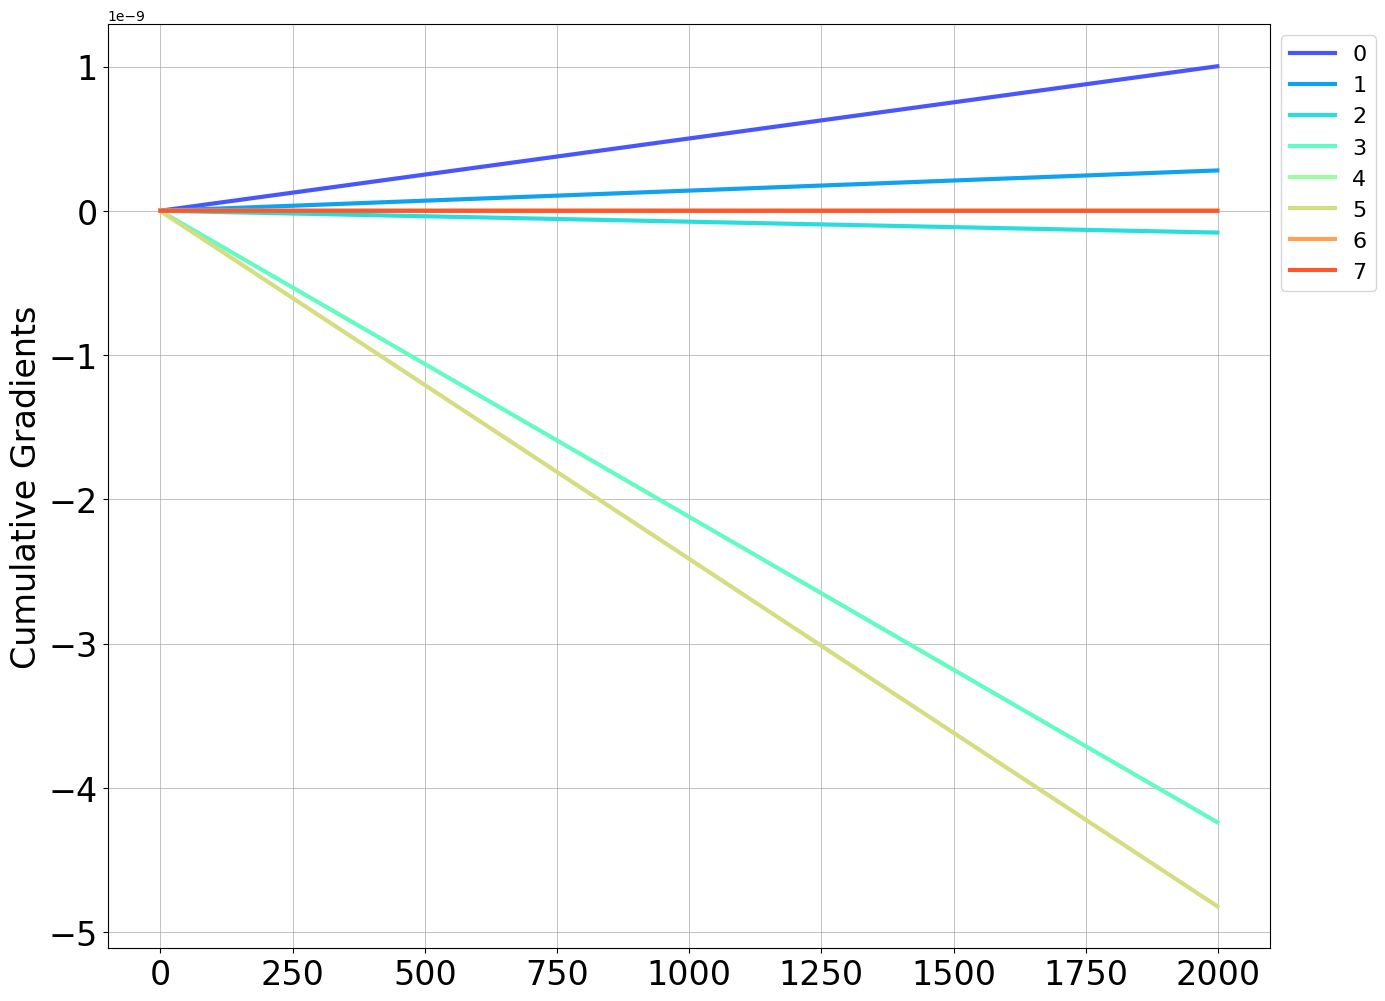

In [8]:
#@title Visualize variable attribution. { vertical-output: false, run: "auto" }

np.set_printoptions(threshold=sys.maxsize)
column_order = madi.utils.sample_utils.get_column_order(ad._normalization_info)
observed_point = {}

################################################################
#vv Copy and paste the text from the cell into the area below.vv
################################################################
print('If you\'re getting an error, please open this cell and paste the output from the last cell here.')

# x001 = 1.096545 #@param {type:"slider", min:-15.843994, max:15.826562, step:0.316706}
# x002 = 1.812443 #@param {type:"slider", min:-15.944197, max:15.917243, step:0.318614}
# x003 = 2.251768 #@param {type:"slider", min:-15.926234, max:15.955971, step:0.318822}
# x004 = 3.677396 #@param {type:"slider", min:-16.005014, max:15.981299, step:0.319863}
# x005 = 2.013382 #@param {type:"slider", min:-15.927835, max:15.942659, step:0.318705}
# x006 = -0.157952 #@param {type:"slider", min:-15.794947, max:15.828419, step:0.316234}
# x007 = 2.872629 #@param {type:"slider", min:-16.020729, max:15.991703, step:0.320124}
# x008 = 1.517368 #@param {type:"slider", min:-15.849610, max:15.862333, step:0.317119}
# x009 = 2.860968 #@param {type:"slider", min:-15.852919, max:15.798532, step:0.316515}
# x010 = 3.641341 #@param {type:"slider", min:-15.926331, max:15.901009, step:0.318273}
# x011 = 2.166058 #@param {type:"slider", min:-15.863787, max:15.834179, step:0.316980}
# x012 = 1.878750 #@param {type:"slider", min:-15.981938, max:15.953093, step:0.319350}
# x013 = 3.558641 #@param {type:"slider", min:-16.009700, max:15.955040, step:0.319647}
# x014 = 2.523611 #@param {type:"slider", min:-15.894705, max:15.889302, step:0.317840}
# x015 = 4.529308 #@param {type:"slider", min:-15.907265, max:15.922067, step:0.318293}
# x016 = 2.449397 #@param {type:"slider", min:-15.909622, max:15.875905, step:0.317855}
# observed_point['x001'] = [x001]
# observed_point['x002'] = [x002]
# observed_point['x003'] = [x003]
# observed_point['x004'] = [x004]
# observed_point['x005'] = [x005]
# observed_point['x006'] = [x006]
# observed_point['x007'] = [x007]
# observed_point['x008'] = [x008]
# observed_point['x009'] = [x009]
# observed_point['x010'] = [x010]
# observed_point['x011'] = [x011]
# observed_point['x012'] = [x012]
# observed_point['x013'] = [x013]
# observed_point['x014'] = [x014]
# observed_point['x015'] = [x015]
# observed_point['x016'] = [x016]

zone_air_heating_temperature_setpoint = 294.259259 #@param {type:"slider", min:250.000000, max:350.000000, step:1.000000}
zone_air_temperature_sensor = 296.148148 #@param {type:"slider", min:250.000000, max:350.000000, step:1.000000}
zone_air_cooling_temperature_setpoint = 297.037037 #@param {type:"slider", min:250.000000, max:350.000000, step:1.000000}
supply_air_flowrate_sensor = 0.058702 #@param {type:"slider", min:-0.524920, max:0.680442, step:0.012054}
supply_air_damper_percentage_command = 0.000000 #@param {type:"slider", min:0.000000, max:100.000000, step:1.000000}
supply_air_flowrate_setpoint = 0.023597 #@param {type:"slider", min:-0.458550, max:0.618666, step:0.010772}
dow = 0.000000 #@param {type:"slider", min:0.000000, max:6.000000, step:1.000000}
hod = 23.000000 #@param {type:"slider", min:0.000000, max:23.000000, step:1.000000}
observed_point['data:zone_air_heating_temperature_setpoint'] = [zone_air_heating_temperature_setpoint]
observed_point['data:zone_air_temperature_sensor'] = [zone_air_temperature_sensor]
observed_point['data:zone_air_cooling_temperature_setpoint'] = [zone_air_cooling_temperature_setpoint]
observed_point['data:supply_air_flowrate_sensor'] = [supply_air_flowrate_sensor]
observed_point['data:supply_air_damper_percentage_command'] = [supply_air_damper_percentage_command]
observed_point['data:supply_air_flowrate_setpoint'] = [supply_air_flowrate_setpoint]
observed_point['dow'] = [dow]
observed_point['hod'] = [hod]



# Sliders should look similar to this:
# zone_air_heating_temperature_setpoint = 285.925926 #@param {type:"slider", min:250.000000, max:350.000000, step:1.000000}
# zone_air_temperature_sensor = 272 #@param {type:"slider", min:250.000000, max:350.000000, step:1.000000}
# zone_air_cooling_temperature_setpoint = 267 #@param {type:"slider", min:250.000000, max:350.000000, step:1.000000}
# supply_air_flowrate_sensor = -0.001365 #@param {type:"slider", min:-0.525120, max:0.680106, step:0.012052}
# supply_air_damper_percentage_command = 100.000000 #@param {type:"slider", min:0.000000, max:100.000000, step:1.000000}
# supply_air_flowrate_setpoint = 0.035396 #@param {type:"slider", min:-0.458984, max:0.618622, step:0.010776}
# dow = 6.000000 #@param {type:"slider", min:0.000000, max:6.000000, step:1.000000}
# hod = 0.000000 #@param {type:"slider", min:0.000000, max:23.000000, step:1.000000}
# observed_point['data:zone_air_heating_temperature_setpoint'] = [zone_air_heating_temperature_setpoint]
# observed_point['data:zone_air_temperature_sensor'] = [zone_air_temperature_sensor]
# observed_point['data:zone_air_cooling_temperature_setpoint'] = [zone_air_cooling_temperature_setpoint]
# observed_point['data:supply_air_flowrate_sensor'] = [supply_air_flowrate_sensor]
# observed_point['data:supply_air_damper_percentage_command'] = [supply_air_damper_percentage_command]
# observed_point['data:supply_air_flowrate_setpoint'] = [supply_air_flowrate_setpoint]
# observed_point['dow'] = [dow]
# observed_point['hod'] = [hod]
################################################################
#^^ Copy and paste the text from the cell into the area above.^^
################################################################

# Get the observed point from the sliders:
df_observed_point = pd.DataFrame(observed_point)

# Since the sliders are shown in orgininal spaces, we should normalize:
df_observed_point_normalized = madi.utils.sample_utils.normalize(df_observed_point, ad._normalization_info)

# Get the anomaly score from the NSNN.
anomaly_score = ad.predict(df_observed_point.copy())['class_prob'][0]

# Call the Blame method that applies Integrated Gradients.
attribution_dict, reference_point_dict, df_grad = interpreter.blame(df_observed_point_normalized.iloc[0])
attribution = pd.Series(attribution_dict)
nearest_reference_point_normalized = pd.Series(reference_point_dict)
df_nearest_reference_point_normalized = nearest_reference_point_normalized.to_frame().T
df_nearest_reference_point = madi.utils.sample_utils.denormalize(df_nearest_reference_point_normalized, ad._normalization_info)
df_attribution = pd.concat([df_observed_point.iloc[0], df_nearest_reference_point.iloc[0], attribution], axis = 1,
                           keys=['observed_value', 'expected_value', 'attribution'], sort = True)

plot_attribution(df_attribution, anomaly_score)

# Plot the attribution as a cumulative curve from reference to observed.
# Use the normalized difference, b/c the model and its gradients are based on
# normalized training data.
delta_normalized = df_nearest_reference_point_normalized.iloc[0] - df_observed_point_normalized.iloc[0]
colnames  = {}
column_order = madi.utils.sample_utils.get_column_order(ad._normalization_info)
for i in range(len(column_order)):
  colnames[i] = column_order[i]

df_grad.set_axis(column_order, axis=1)# inplace=True omitted
plot_gradient_series(df_grad, delta_normalized)

# TODO(sipple) from review:
# Particularly for smart buildings, it would be cool to have the option to see
# the attributions and the cumulative gradients for an anomaly, something like:
# EXAMPLE_TYPE = 'reference point' #@param ['reference point', 'anomaly']

# if EXAMPLE_TYPE == 'reference point':
#   df_reference_point_selected_normalized = interpreter._df_baseline.sample(1)
#   df_point_selected = madi.utils.sample_utils.denormalize(df_reference_point_selected_normalized, ad._normalization_info)
# elif EXAMPLE_TYPE == 'anomaly':
#   df_point_selected = test_sample[test_sample.class_label == 0].sample(1)
# else:
#   raise NotImplementedError
